In [1]:
import os
import torch
import numpy as np
from tqdm import tqdm
from argparse import ArgumentParser
from datasets import init_dataloaders
from models.detector import OVDDetector
from datasets import get_base_new_classes
from utils_dir.nms import custom_xywh2xyxy
from utils_dir.metrics import ap_per_class, box_iou
from utils_dir.processing_utils import map_labels_to_prototypes
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import colorsys

/home/gridsan/manderson/.conda/envs/test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gridsan/manderson/.local/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
print(torch.cuda.is_available())

True


In [33]:
# VAR

DATA_DIR='data'
backbone='clip-14' #openclip-14 #dinov2 #georsclip-14 #remoteclip-14
dataset='simd'
finetune='init_prototypes' #init_prototypes or train
finetune_type='boxes' #masks or boxes
N=10
INIT_PROTOTYPES_PATH='run/init_prototypes'

In [34]:
# Create an ArgumentParser object
parser = ArgumentParser()

# Add your arguments as usual
parser.add_argument('--dataset', type=str)
parser.add_argument('--val_root_dir', type=str)
parser.add_argument('--val_annotations_file', type=str)
parser.add_argument('--annotations', type=str, default='box')
parser.add_argument('--prototypes_path', type=str)
parser.add_argument('--bg_prototypes_path', type=str, default=None)
parser.add_argument('--aggregation', type=str, default='mean')
parser.add_argument('--classification', type=str, default='box')
parser.add_argument('--save_dir', type=str, default=None)
parser.add_argument('--backbone_type', type=str, default='dinov2')
parser.add_argument('--target_size', nargs=2, type=int, metavar=('width', 'height'), default=[560, 560])
parser.add_argument('--batch_size', type=int, default=1)
parser.add_argument('--num_workers', type=int, default=8)
parser.add_argument('--scale_factor', nargs='+', type=int, default=[2])
parser.add_argument('--iou_thr', type=float, default=0.2)
parser.add_argument('--conf_thres', type=float, default=0.001)

_StoreAction(option_strings=['--conf_thres'], dest='conf_thres', nargs=None, const=None, default=0.001, type=<class 'float'>, choices=None, required=False, help=None, metavar=None)

In [35]:
args = parser.parse_args([
    '--dataset', dataset,
    '--val_root_dir', f'{DATA_DIR}/{dataset}/val',
    '--save_dir', f'run/test/detection/{dataset}/{finetune}/backbone_{backbone}_{finetune_type}/N{N}',
    '--val_annotations_file', f'{DATA_DIR}/{dataset}/val_coco.json',
    '--prototypes_path', f'run/{finetune}/{finetune_type}/{dataset}_N{N}/prototypes_{backbone}.pt',
    '--bg_prototypes_path', f'run/init_prototypes/boxes/{dataset}_N{N}/bg_prototypes_{backbone}.pt',
    '--backbone_type', backbone,
    '--classification', 'box',
    '--target_size', '602', '602',
    '--batch_size', '1',
    '--num_workers', '8',
    '--scale_factor', '1'
])

In [25]:
def prepare_model(args):
    '''
    Loads the model to evaluate given the input arguments and returns it.
    
    Args:
        args (argparse.Namespace): Input arguments
    '''

    # Use GPU if available
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    # Load prototypes and background prototypes
    prototypes = torch.load(args.prototypes_path)
    print(f'Using object prototypes from {args.prototypes_path}')
    bg_prototypes = torch.load(args.bg_prototypes_path) if args.bg_prototypes_path is not None else None
    if args.bg_prototypes_path is not None:
        print(f'Using background prototypes from {args.bg_prototypes_path}')
    model = OVDDetector(prototypes, bg_prototypes, scale_factor=args.scale_factor, backbone_type=args.backbone_type, target_size=args.target_size, classification=args.classification).to(device)
    #model.eval() 
    return model, device

In [26]:
def process_batch(detections, labels, iouv):
    """
    Return correct prediction matrix
    Arguments:
        detections (array[N, 6]), x1, y1, x2, y2, conf, class (predicted)
        labels (array[M, 5]), class, x1, y1, x2, y2 (GT)
    Returns:
        correct (array[N, 10]), for 10 IoU levels
    """
    correct = np.zeros((detections.shape[0], iouv.shape[0])).astype(bool)
    iou = box_iou(labels[:, 1:], detections[:, :4])
    correct_class = labels[:, 0:1] == detections[:, 5]
    for i in range(len(iouv)):
        x = torch.where((iou >= iouv[i]) & correct_class)  # IoU > threshold and classes match
        if x[0].shape[0]:
            matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1).cpu().numpy()  # [label, detect, iou]
            if x[0].shape[0] > 1:
                matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
                # matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
            correct[matches[:, 1].astype(int), i] = True
    return torch.tensor(correct, dtype=torch.bool, device=iouv.device)

In [8]:
def generate_uniform_colors(n):
    """Generate n colors spread uniformly across the color spectrum in HSV space."""
    hsv_colors = np.zeros((n, 3))
    h_vals = np.linspace(0, 1, n)
    
    # Convert HSV to RGB
    # Saturation and Value are set to 1 for full color intensity
    rgb_colors = []
    for h in h_vals:
        rgb_colors.append(colorsys.hsv_to_rgb(h, 1, 1))
        
    print(rgb_colors)
    
    return rgb_colors

def create_uniform_cmap(n):
    """Create a ListedColormap with n colors spread uniformly across the color spectrum."""
    colors = generate_uniform_colors(n)
    return ListedColormap(colors)

In [9]:
def viz_bbox_labels(img, boxes, labels, names, cmap, title=None):
    '''
    Args:
        img (array[x,y,3])
        boxes (array[N, 4])
        labels (array[N])
        names
        cmap 
        title (str)
    '''
    
    img = img.cpu()
    boxes = boxes.cpu()
    labels = labels.cpu()
    
    # Create figure and axis
    fig, ax = plt.subplots(1)
    
    # Display the image
    ax.imshow(img)
    
    # Get unique labels and create colormap
    unique_labels = np.unique(labels)
    #cmap = ListedColormap([plt.cm.hsv(i / len(unique_labels)) for i in range(len(unique_labels))])
    
    # Iterate over each bounding box and draw rectangle and label
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box
        
        # Calculate box width and height
        box_width = x_max - x_min
        box_height = y_max - y_min
        
        # Create a Rectangle patch
        rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=1, edgecolor=cmap(int(label)), facecolor='none')
        
        # Add the patch to the plot
        ax.add_patch(rect)
        
        # Display label number next to the box
        ax.text(x_min, y_min, names[int(label.item())], fontsize=8, va='top', color='white', bbox=dict(facecolor=cmap(int(label)), alpha=0.5))
    
    # Set title
    ax.set_title(title)
    
    # Turn off the axis
    ax.axis('off')
    
    # Show the plt
    plt.show()

In [10]:
def eval_detection(args, model, val_dataloader, device):
    seen = 0
    iouv = torch.linspace(0.5, 0.95, 10, device=device)  # iou vector for mAP@0.5:0.95
    nc = val_dataloader.dataset.get_category_number()
    names = model.classifier.get_categories()
    stats = []
    with torch.no_grad():
        for i, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader), leave=False):
            if args.classification != 'mask':
                images, boxes, labels, metadata = batch
                boxes = boxes.to(device)
            else:
                images, _, labels, masks, _ = batch
                loc = masks.float().to(device)
            
            labels = map_labels_to_prototypes(val_dataloader.dataset.get_categories(), model.classifier.get_categories(), labels)
            images = images.float().to(device)
            labels = labels.to(device)
            preds = model(images, iou_thr=args.iou_thr, conf_thres=args.conf_thres, aggregation=args.aggregation) #pred - x1, y1, x2, y2, conf, class
            for si, pred in enumerate(preds):
                keep = labels[si] > -1
                targets = labels[si, keep]
                nl, npr = targets.shape[0], pred.shape[0]  # number of labels, predictions
                correct = torch.zeros(npr, len(iouv), dtype=torch.bool, device=device)  # init
                seen += 1
                if npr == 0:
                    if nl:
                        stats.append((correct, *torch.zeros((2, 0), device=device), targets[:]))
                    continue
                    
                predn = pred.clone()
                if nl:
                    tbox = custom_xywh2xyxy(boxes[si, keep, :])  # target boxes
                    labelsn = torch.cat((targets[..., None], tbox), 1)  # native-space labels (class, x1, y1, x2, y2)
                    correct = process_batch(predn, labelsn, iouv)
                stats.append((correct, pred[:, 4], pred[:, 5], targets[:]))
    stats = [torch.cat(x, 0).cpu().numpy() for x in zip(*stats)]  # to numpy
    #mp, mr, map50, map, ap_class = 0, 0, 0, 0, 0
    if len(stats) and stats[0].any():
        tp, fp, p, r, f1, ap, ap_class = ap_per_class(*stats, names=names)
        ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
        mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
    nt = np.bincount(stats[3].astype(int), minlength=nc)  # number of targets per class
    pf = '%22s' + '%11i' * 2 + '%11.3g' * 4  # print format
    s = ('%22s' + '%11s' * 6) % ('Class', 'Images', 'Instances', 'P', 'R', 'mAP50', 'mAP50-95')
    print(s)
    print(pf % ('all', seen, nt.sum(), mp, mr, map50, map))
    if nc > 1 and len(stats):
        for i, c in enumerate(ap_class):
            print(pf % (names[c], seen, nt[c], p[i], r[i], ap50[i], ap[i]))
    if args.save_dir is not None:
        os.makedirs(args.save_dir, exist_ok=True)
        filename = 'results_{}.txt'.format(args.backbone_type)
        save_file_path = os.path.join(args.save_dir, filename)
        base_classes, new_classes = get_base_new_classes(args.dataset)
        with open(save_file_path, 'w') as file:
            file.write('Class Images Instances P R mAP50 mAP50-95\n')
            file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % ('all', seen, nt.sum(), mp, mr, map50, map))
            if nc > 1 and len(stats):
                map50_base = map_base = mr_base = mp_base = 0
                map50_new = map_new = mr_new = mp_new = 0
                for i, c in enumerate(ap_class):
                    file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % (names[c], seen, nt[c], p[i], r[i], ap50[i], ap[i]))
                    if names[c] in base_classes:
                        map50_base += ap50[i]
                        map_base += ap[i]
                        mr_base += r[i]
                        mp_base += p[i]
                    elif names[c] in new_classes:
                        map50_new += ap50[i]
                        map_new += ap[i]
                        mr_new += r[i]
                        mp_new += p[i]
                map50_base /= len(base_classes)
                map_base /= len(base_classes)
                mr_base /= len(base_classes)
                mp_base /= len(base_classes)
                map50_new /= len(new_classes)
                map_new /= len(new_classes)
                mr_new /= len(new_classes)
                mp_new /= len(new_classes)
                file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % ('total base', seen, nt.sum(), mp_base, mr_base, map50_base, map_base))
                file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % ('total new', seen, nt.sum(), mp_new, mr_new, map50_new, map_new))

In [39]:
def eval_detection_debug(args, model, val_dataloader, device):
    seen = 0
    iouv = torch.linspace(0.5, 0.95, 10, device=device)  # iou vector for mAP@0.5:0.95
    print('iou levels:', iouv)
    nc = val_dataloader.dataset.get_category_number()
    print(nc, 'categories in dataset')
    names = model.classifier.get_categories()
    print('Category names:', names)
    stats = []
    viz_cmap = create_uniform_cmap(nc)
    with torch.no_grad():
        for i, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader), leave=False):
            if i > 5:
                break
            if args.classification != 'mask':
                images, boxes, labels, metadata = batch
                boxes = boxes.to(device)
            else:
                images, _, labels, masks, _ = batch
                loc = masks.float().to(device)
                
            print('Image shape:', images.shape)
            rgb = images[0].permute(1, 2, 0)
            rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
            plt.imshow(rgb)
            
            print('Boxes shape:', boxes.shape)
            print('GT labels shape:', labels.shape)
            #print('GT labels:\n', labels)
            
            labels = map_labels_to_prototypes(val_dataloader.dataset.get_categories(), model.classifier.get_categories(), labels)
            images = images.float().to(device)
            labels = labels.to(device)
            preds = model(images, iou_thr=args.iou_thr, conf_thres=args.conf_thres, aggregation=args.aggregation) # TODO: why is preds empty when using clip models?
            #print('Labels with prototype numbers:\n', labels)

            print('Pred - x1, y1, x2, y2, conf, class:', preds[0].shape)
            print(preds[0])
            
            for si, pred in enumerate(preds):
                keep = labels[si] > -1
                #print(keep.shape)
                #print(keep)
                targets = labels[si, keep]
                print('Targets (non-background GT objects):')
                print(targets)
                nl, npr = targets.shape[0], pred.shape[0]  # number of labels, predictions
                print(nl, 'GT labels,', npr, 'predictions')
                if npr==0:
                    print('WARNING: no detections')
                correct = torch.zeros(npr, len(iouv), dtype=torch.bool, device=device)  # init
                seen += 1
                if npr == 0:
                    if nl:
                        stats.append((correct, *torch.zeros((2, 0), device=device), targets[:]))
                    continue
                    
                predn = pred.clone()
                if nl:
                    tbox = custom_xywh2xyxy(boxes[si, keep, :])  # target boxes
                    print('target boxes\n', tbox)
                    labelsn = torch.cat((targets[..., None], tbox), 1)  # native-space labels
                    print('labelsn:', labelsn.shape)
                    print(labelsn)
                    correct = process_batch(predn, labelsn, iouv) #correct (array[N, 10]), for 10 IoU levels for each prediction
                    print('correct:', correct.shape)
                    print(correct)
                    
                # TODO insert viz script: call another function that takes in image, boxes, and labels for GT and prediction
                print('Visualizing')
                viz_bbox_labels(rgb, tbox, labelsn[:,0], names, viz_cmap, 'GT') # GT
                viz_bbox_labels(rgb, pred[:,:4], pred[:,5], names, viz_cmap, 'Predicted') # Predicted
                    
                stats.append((correct, pred[:, 4], pred[:, 5], targets[:]))
    stats = [torch.cat(x, 0).cpu().numpy() for x in zip(*stats)]  # to numpy
    print('stats len', len(stats))
    for stat in stats:
        print(stat)
    print('Any correct detections?', stats[0].any())
    #if len(stats) and stats[0].any():
    if len(stats):
        tp, fp, p, r, f1, ap, ap_class = ap_per_class(*stats, names=names) # these results based on TPs and FPs of target (gt)
        ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
        mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
    else:
        print('WARNING: no correct detections.')
    nt = np.bincount(stats[3].astype(int), minlength=nc)  # number of targets per class
    pf = '%22s' + '%11i' * 2 + '%11.3g' * 4  # print format
    s = ('%22s' + '%11s' * 6) % ('Class', 'Images', 'Instances', 'P', 'R', 'mAP50', 'mAP50-95')
    print(s)
    print(pf % ('all', seen, nt.sum(), mp, mr, map50, map))
    if nc > 1 and len(stats):
        for i, c in enumerate(ap_class):
            print(pf % (names[c], seen, nt[c], p[i], r[i], ap50[i], ap[i]))
    if args.save_dir is not None:
        os.makedirs(args.save_dir, exist_ok=True)
        filename = 'results_{}.txt'.format(args.backbone_type)
        save_file_path = os.path.join(args.save_dir, filename)
        base_classes, new_classes = get_base_new_classes(args.dataset)
        with open(save_file_path, 'w') as file:
            file.write('Class Images Instances P R mAP50 mAP50-95\n')
            file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % ('all', seen, nt.sum(), mp, mr, map50, map))
            if nc > 1 and len(stats):
                map50_base = map_base = mr_base = mp_base = 0
                map50_new = map_new = mr_new = mp_new = 0
                for i, c in enumerate(ap_class):
                    file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % (names[c], seen, nt[c], p[i], r[i], ap50[i], ap[i]))
                    if names[c] in base_classes:
                        map50_base += ap50[i]
                        map_base += ap[i]
                        mr_base += r[i]
                        mp_base += p[i]
                    elif names[c] in new_classes:
                        map50_new += ap50[i]
                        map_new += ap[i]
                        mr_new += r[i]
                        mp_new += p[i]
                map50_base /= len(base_classes)
                map_base /= len(base_classes)
                mr_base /= len(base_classes)
                mp_base /= len(base_classes)
                map50_new /= len(new_classes)
                map_new /= len(new_classes)
                mr_new /= len(new_classes)
                mp_new /= len(new_classes)
                file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % ('total base', seen, nt.sum(), mp_base, mr_base, map50_base, map_base))
                file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % ('total new', seen, nt.sum(), mp_new, mr_new, map50_new, map_new))

In [36]:
# Load data
_, val_dataloader = init_dataloaders(args)

In [37]:
# Load model
model, device = prepare_model(args)

Using object prototypes from run/init_prototypes/boxes/simd_N10/prototypes_clip-14.pt
Using background prototypes from run/init_prototypes/boxes/simd_N10/bg_prototypes_clip-14.pt


iou levels: tensor([0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500, 0.9000,
        0.9500], device='cuda:0')
15 categories in dataset
Category names: {0: 'figther-aircraft', 1: 'helicopter', 2: 'long-vehicle', 3: 'stair-truck', 4: 'boat', 5: 'van', 6: 'others', 7: 'car', 8: 'trainer-aircraft', 9: 'propeller-aircraft', 10: 'bus', 11: 'pushback-truck', 12: 'airliner', 13: 'truck', 14: 'charted-aircraft'}
[(1, 0.0, 0.0), (1, 0.4285714285714286, 0.0), (1, 0.8571428571428571, 0.0), (0.7142857142857144, 1, 0.0), (0.2857142857142858, 1, 0.0), (0.0, 1, 0.14285714285714235), (0.0, 1, 0.5714285714285712), (0.0, 1.0, 1), (0.0, 0.5714285714285716, 1), (0.0, 0.14285714285714324, 1), (0.2857142857142847, 0.0, 1), (0.7142857142857144, 0.0, 1), (1, 0.0, 0.8571428571428577), (1, 0.0, 0.4285714285714288), (1, 0.0, 0.0)]


  0%|          | 0/1000 [00:00<?, ?it/s]

Image shape: torch.Size([1, 3, 602, 602])
Boxes shape: torch.Size([1, 500, 4])
GT labels shape: torch.Size([1, 500])
Pred - x1, y1, x2, y2, conf, class: torch.Size([5, 6])
tensor([[3.6745e+02, 1.6620e+02, 4.1226e+02, 1.9153e+02, 6.3806e-01, 2.0000e+00],
        [3.6164e+02, 1.0461e+02, 4.0872e+02, 1.2998e+02, 6.1978e-01, 2.0000e+00],
        [1.8095e+02, 2.7074e+02, 2.2173e+02, 2.9481e+02, 5.5074e-01, 7.0000e+00],
        [1.8111e+02, 3.0346e+02, 2.2037e+02, 3.2611e+02, 4.8045e-01, 7.0000e+00],
        [3.2782e+02, 5.1234e+02, 4.0531e+02, 5.3541e+02, 1.2518e-01, 2.0000e+00]],
       device='cuda:0')
Targets (non-background GT objects):
tensor([ 5,  7,  7,  7, 13, 13,  5,  7, 13], device='cuda:0')
9 GT labels, 5 predictions
target boxes
 tensor([[362.7285, 101.9010, 412.1113, 134.0391],
        [181.6582, 189.6927, 222.8105, 219.4792],
        [178.1309, 234.3724, 222.8105, 264.1588],
        [178.7188, 264.1588, 223.9863, 295.5130],
        [175.1914, 459.3385, 263.3750, 498.5312],
   

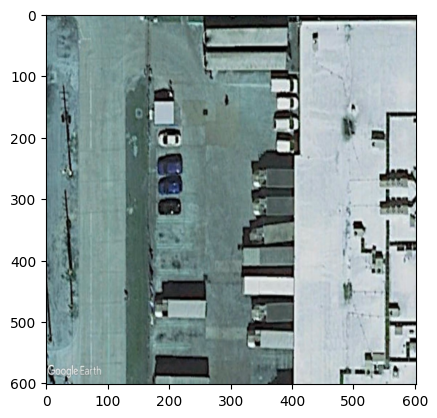

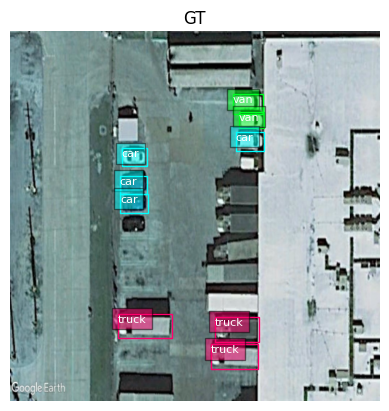

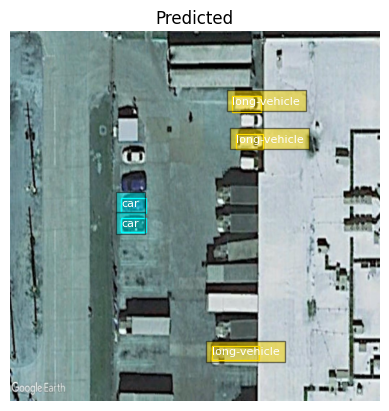

  0%|          | 1/1000 [00:01<22:28,  1.35s/it]

Image shape: torch.Size([1, 3, 602, 602])
Boxes shape: torch.Size([1, 500, 4])
GT labels shape: torch.Size([1, 500])
Pred - x1, y1, x2, y2, conf, class: torch.Size([18, 6])
tensor([[3.8725e+02, 2.9193e+02, 4.1935e+02, 3.8512e+02, 6.3709e-01, 1.0000e+01],
        [3.5450e+02, 2.8700e+02, 3.8718e+02, 3.8887e+02, 6.0656e-01, 9.0000e+00],
        [4.1764e+02, 2.4799e+02, 4.5583e+02, 3.7263e+02, 5.9137e-01, 1.0000e+01],
        [2.4148e+02, 7.5172e+01, 3.2992e+02, 1.2518e+02, 5.7066e-01, 2.0000e+00],
        [3.2495e+02, 2.9109e+02, 3.5733e+02, 3.9303e+02, 5.6266e-01, 9.0000e+00],
        [2.1741e+02, 4.0551e+02, 2.9398e+02, 4.4985e+02, 5.5627e-01, 2.0000e+00],
        [2.5239e+02, 2.0318e+02, 2.8428e+02, 2.8932e+02, 5.5556e-01, 1.0000e+01],
        [3.8217e+02, 1.5316e+02, 4.1501e+02, 2.7745e+02, 5.5095e-01, 4.0000e+00],
        [9.4604e+01, 3.9931e+02, 1.8750e+02, 4.5246e+02, 5.3708e-01, 2.0000e+00],
        [2.0681e+02, 3.2274e+02, 2.3763e+02, 3.9875e+02, 5.0371e-01, 2.0000e+00],
       

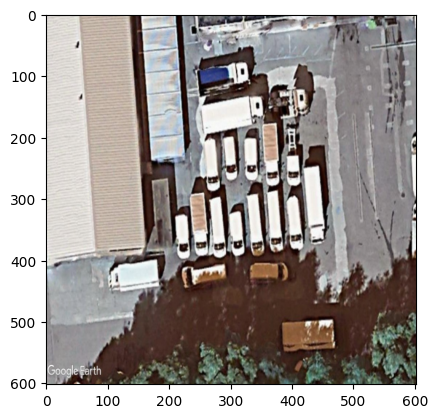

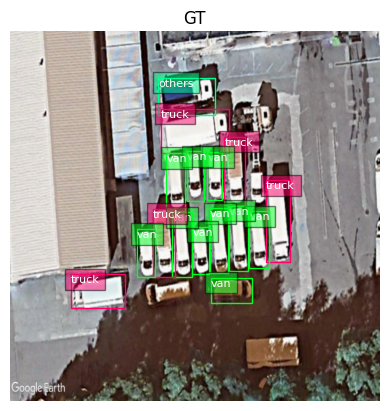

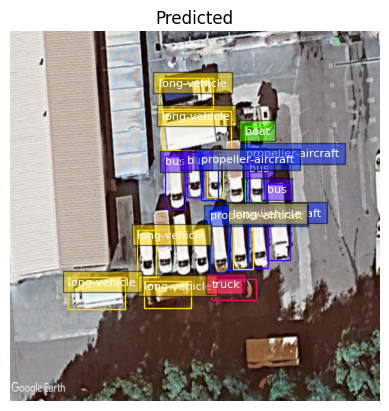

  0%|          | 2/1000 [00:02<18:30,  1.11s/it]

Image shape: torch.Size([1, 3, 602, 602])
Boxes shape: torch.Size([1, 500, 4])
GT labels shape: torch.Size([1, 500])
Pred - x1, y1, x2, y2, conf, class: torch.Size([6, 6])
tensor([[2.1357e+02, 2.1926e+02, 2.7645e+02, 2.6878e+02, 6.3131e-01, 7.0000e+00],
        [2.7097e+02, 4.8205e+00, 3.3220e+02, 5.3832e+01, 5.6616e-01, 7.0000e+00],
        [1.9827e+02, 2.5252e+02, 2.5570e+02, 3.0080e+02, 5.6056e-01, 2.0000e+00],
        [2.2372e+02, 1.8682e+02, 2.8377e+02, 2.3338e+02, 5.2251e-01, 7.0000e+00],
        [2.5526e+02, 8.8999e+01, 3.0802e+02, 1.2699e+02, 2.8992e-01, 7.0000e+00],
        [2.0672e+02, 2.1741e+02, 2.6372e+02, 2.6653e+02, 2.4747e-02, 2.0000e+00]],
       device='cuda:0')
Targets (non-background GT objects):
tensor([7, 7, 7, 7, 7], device='cuda:0')
5 GT labels, 6 predictions
target boxes
 tensor([[275.1328,   6.2708, 330.3945,  54.8698],
        [222.2227, 182.6380, 281.0117, 230.4531],
        [214.5801, 219.4792, 273.9570, 268.8620],
        [196.9434, 250.8333, 252.2051, 304

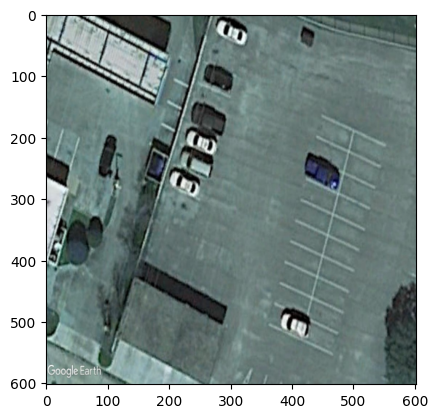

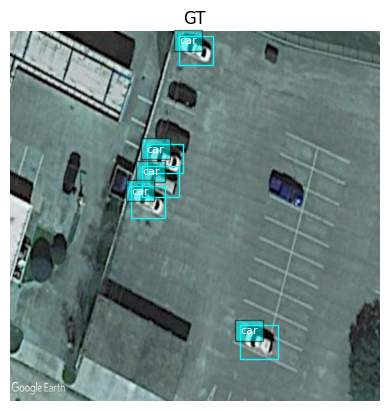

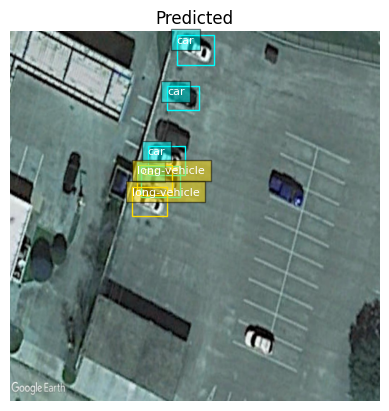

  0%|          | 3/1000 [00:03<16:38,  1.00s/it]

Image shape: torch.Size([1, 3, 602, 602])
Boxes shape: torch.Size([1, 500, 4])
GT labels shape: torch.Size([1, 500])
Pred - x1, y1, x2, y2, conf, class: torch.Size([11, 6])
tensor([[2.1558e+02, 3.8743e+02, 2.9023e+02, 4.5225e+02, 6.1477e-01, 4.0000e+00],
        [1.3384e+02, 1.5145e+02, 2.3213e+02, 2.2667e+02, 5.8583e-01, 4.0000e+00],
        [4.2578e+02, 2.4227e+02, 4.8492e+02, 3.0020e+02, 5.8467e-01, 4.0000e+00],
        [1.4103e+02, 2.0498e+02, 2.4088e+02, 2.8217e+02, 5.6149e-01, 4.0000e+00],
        [1.9830e+02, 3.2418e+02, 2.6969e+02, 3.8663e+02, 5.5301e-01, 4.0000e+00],
        [1.8598e+02, 2.5464e+02, 2.5346e+02, 3.0871e+02, 4.9295e-01, 4.0000e+00],
        [4.3205e+02, 2.5849e+02, 5.9928e+02, 5.9481e+02, 3.9674e-01, 4.0000e+00],
        [2.1711e+02, 2.2153e+02, 4.1464e+02, 6.0200e+02, 3.6666e-01, 4.0000e+00],
        [1.9620e+02, 2.9600e+02, 2.4562e+02, 3.3802e+02, 1.1668e-01, 4.0000e+00],
        [1.4626e+02, 8.3540e+01, 3.6820e+02, 3.5363e+02, 5.9742e-02, 4.0000e+00],
       

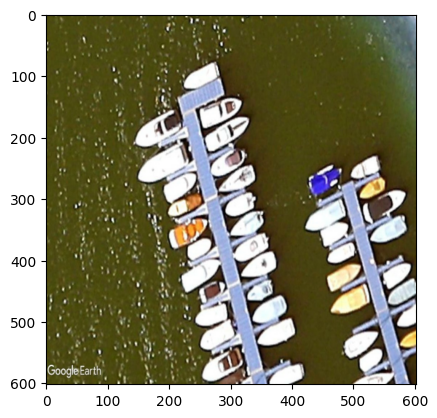

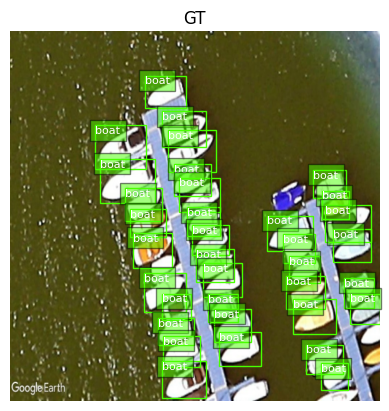

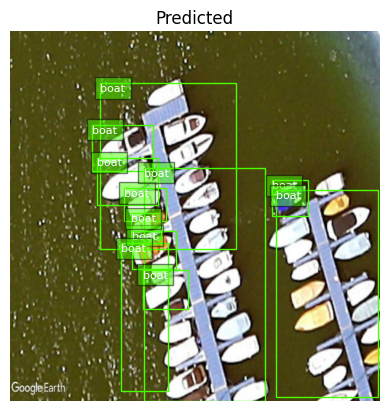

  0%|          | 4/1000 [00:04<16:26,  1.01it/s]

Image shape: torch.Size([1, 3, 602, 602])
Boxes shape: torch.Size([1, 500, 4])
GT labels shape: torch.Size([1, 500])
Pred - x1, y1, x2, y2, conf, class: torch.Size([1, 6])
tensor([[ 29.0421,   0.0000, 551.9533, 563.3979,   0.5825,   9.0000]],
       device='cuda:0')
Targets (non-background GT objects):
tensor([12], device='cuda:0')
1 GT labels, 1 predictions
target boxes
 tensor([[125.8086,  33.7057, 458.5547, 457.7708]], device='cuda:0')
labelsn: torch.Size([1, 5])
tensor([[ 12.0000, 125.8086,  33.7057, 458.5547, 457.7708]], device='cuda:0')
correct: torch.Size([1, 10])
tensor([[False, False, False, False, False, False, False, False, False, False]],
       device='cuda:0')
Visualizing


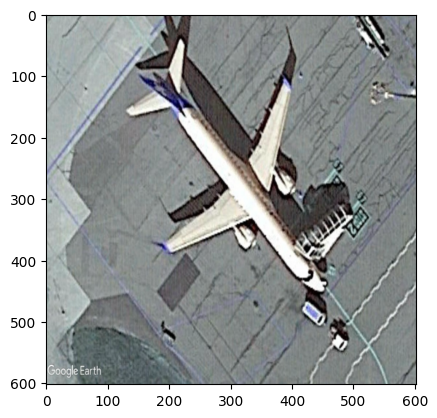

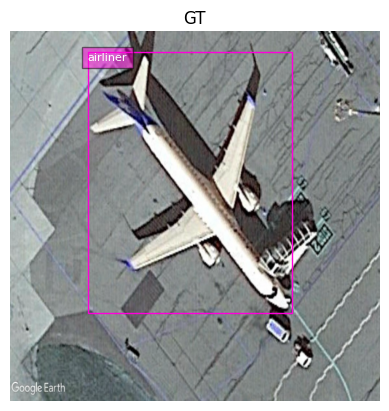

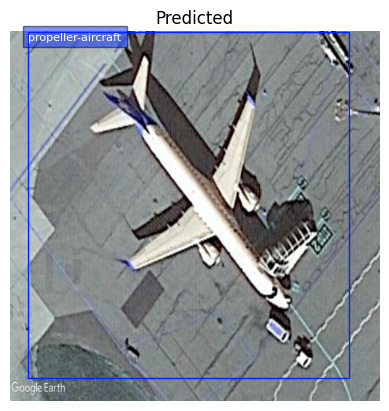

  0%|          | 5/1000 [00:05<17:49,  1.07s/it]

Image shape: torch.Size([1, 3, 602, 602])
Boxes shape: torch.Size([1, 500, 4])
GT labels shape: torch.Size([1, 500])
Pred - x1, y1, x2, y2, conf, class: torch.Size([1, 6])
tensor([[ 87.0756, 122.9134, 344.3247, 407.9601,   0.6379,   9.0000]],
       device='cuda:0')
Targets (non-background GT objects):
tensor([14], device='cuda:0')
1 GT labels, 1 predictions
target boxes
 tensor([[142.2695, 166.1771, 293.9453, 380.9531]], device='cuda:0')
labelsn: torch.Size([1, 5])
tensor([[ 14.0000, 142.2695, 166.1771, 293.9453, 380.9531]], device='cuda:0')
correct: torch.Size([1, 10])
tensor([[False, False, False, False, False, False, False, False, False, False]],
       device='cuda:0')
Visualizing


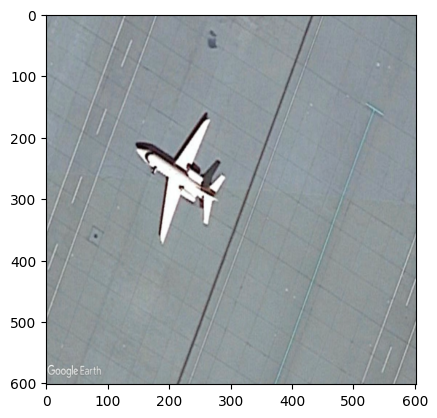

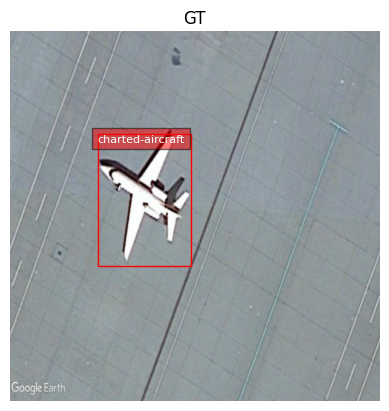

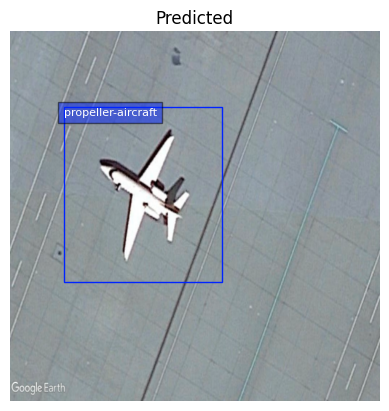

stats len 4
[[False False False False False False False False False False]
 [False False False False False False False False False False]
 [ True  True  True  True False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False

In [40]:
# Walk through training
eval_detection_debug(
    args, 
    model, 
    val_dataloader, 
    device
)

In [ ]:
# Perform training
eval_detection(
    args, 
    model, 
    val_dataloader, 
    device
)